In [5]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import scale, StandardScaler,FunctionTransformer
from sklearn.metrics import roc_curve, auc,confusion_matrix,roc_auc_score,precision_recall_curve

import matplotlib.pyplot as plt
#import shap

In [6]:
election = pd.read_csv('../data/clean_s_round_elect_results.csv', sep=',')
demographie = pd.read_csv('../data/data_demographie_clean.csv', sep=';').drop('Label',1)
education = pd.read_csv('../data/data_education_clean.csv', sep=';')
immobilier = pd.read_csv('../data/data_immobilier_clean.csv', sep=';').drop('Label',1)

mdb = pd.read_csv("../data/mdb_clean.csv", dtype = {'Code Insee': str})

In [7]:
print(election.shape)
print(demographie.shape)
print(education.shape)
print(immobilier.shape)

print(mdb.shape)

(35393, 6)
(34915, 14)
(34947, 6)
(34947, 8)
(36677, 97)


In [8]:
df_final = demographie.merge(election, how='inner', left_on='Code', right_on='Code Insee')
df_final = df_final.merge(education, how='inner', left_on='Code', right_on='Code')
df_final = df_final.merge(immobilier, how='inner', left_on='Code', right_on='Code')
df_final.shape

(34915, 32)

In [9]:
# We create a target column called 'winner'
df_final['winner']= np.where(df_final['LE PEN'] > df_final['MACRON'], 0, 1)
# We remove unwanted features
df_final = df_final.drop(['Inscrits','Libellé de la commune','% Abs/Ins','MACRON','LE PEN','libellé','Code Insee'],1)

In [10]:
Code = df_final['Code']
df_final = df_final.drop('Code',1)

In [11]:
print(df_final.shape)
print(df_final[df_final['winner'] == 0].shape)
print(df_final[df_final['winner'] == 1].shape)

(34915, 25)
(9073, 25)
(25842, 25)


In [12]:
X = df_final.drop(['winner'],1)
y = df_final['winner']

In [73]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
"""
df_final = df_final.sort_values(['winner'])

x_train_le_pen = df_final.iloc[:7000,:-1]
x_train_macron = df_final.iloc[9073:18000,:-1]

y_train_le_pen = df_final.iloc[:7000,-1]
y_train_macron = df_final.iloc[9073:18000,-1]

x_train = pd.concat([x_train_le_pen,x_train_macron])
y_train = pd.concat([y_train_le_pen,y_train_macron])

x_test_le_pen = df_final.iloc[7000:9073,:-1]
x_test_macron = df_final.iloc[18000:21000,:-1]

y_test_le_pen = df_final.iloc[7000:9073,-1]
y_test_macron = df_final.iloc[18000:21000,-1]

x_test = pd.concat([x_test_le_pen,x_test_macron])
y_test = pd.concat([y_test_le_pen,y_test_macron])
"""

In [74]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(23393, 24)
(23393,)
(11522, 24)
(11522,)


In [75]:
print('Ratio de valeur positive dans la target : ',y_train[y==1].shape[0]/y_train.shape[0])

Ratio de valeur positive dans la target :  0.7416748600008549


In [76]:
#We use sklearn scaler for scaling our data quickly
scaler = StandardScaler()
clf_rf = RandomForestClassifier()
clf_lr = LogisticRegression(solver='liblinear')

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test= scaler.transform(x_test)

In [77]:
# Find best parameters for random forrest on cross val
param_grid_rf = {"n_estimators" : [100,200],
                 "max_depth" : [2,3]
                }
gridsearch_rf = GridSearchCV(clf_rf,param_grid=param_grid_rf, 
                             cv=10, 
                             scoring='accuracy', 
                             return_train_score=True,
                             refit=True)
# Find best parameters for logistic regression on cross val
param_grid_lr = {"C" : [0.001,0.01,0.05,0.1,1.0]}
gridsearch_lr = GridSearchCV(clf_lr,param_grid=param_grid_lr, 
                             cv=10, 
                             scoring='accuracy', 
                             return_train_score=True,
                             refit=True)


gridsearch_lr.fit(x_train, y_train.values.ravel())
pd.DataFrame(gridsearch_lr.cv_results_).T

,0,1,2,3,4
mean_fit_time,0.121939,0.17252,0.206967,0.209451,0.226393
std_fit_time,0.0146602,0.00433488,0.00795282,0.0124203,0.0126257
mean_score_time,0.00100005,0.000986028,0.000985694,0.000989604,0.00109093
std_score_time,2.30811e-05,1.48724e-05,1.73493e-05,0.000441734,0.000301654
param_C,0.001,0.01,0.05,0.1,1
params,{'C': 0.001},{'C': 0.01},{'C': 0.05},{'C': 0.1},{'C': 1.0}
split0_test_score,0.798291,0.801282,0.799573,0.8,0.800427
split1_test_score,0.789744,0.79188,0.789744,0.790598,0.791026
split2_test_score,0.785043,0.790171,0.787607,0.788462,0.788462
split3_test_score,0.769987,0.771697,0.772552,0.773407,0.773835


In [78]:
clf_rf = RandomForestClassifier(n_estimators = 400,max_depth = 3)
clf_lr = clf_lr = LogisticRegression(solver='liblinear', C=0.1)

clf_rf.fit(x_train,y_train)
clf_lr.fit(x_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
len(clf_rf.feature_importances_)

columns_importancy = pd.DataFrame(X.columns, columns=['column'])
columns_importancy['importancy_rf'] = clf_rf.feature_importances_
columns_importancy['importancy_lr'] = clf_lr.coef_.T

columns_importancy

,column,importancy_rf,importancy_lr
0,pop,0.052389,0.549178
1,1_child-25,0.001473,-0.093627
2,Indice_vieillissement,0.075003,-0.157023
3,density_pop,0.010263,-0.014304
4,evol_pop,0.002021,0.036786
5,pop-15y,0.021423,0.142862
6,pop-25y,0.050883,-0.438049
7,pop-64y,0.004592,-0.192779
8,pop+65y,0.105099,0.494847
9,fmly_no_child-25,0.014966,0.006897


AttributeError: 'AxesSubplot' object has no attribute 'savefig'

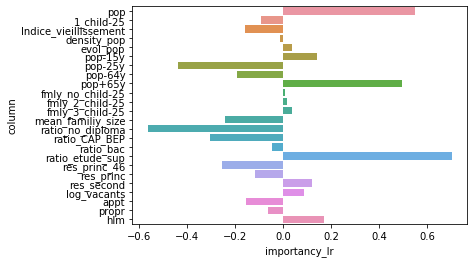

In [81]:
import seaborn as sns

ax = sns.barplot(x="importancy_lr", y="column", data=columns_importancy)

In [68]:
y_result = gridsearch_lr.predict_proba(x_test)[:,1]
y_train_result = gridsearch_lr.predict_proba(x_train)[:,1]

### ROC curve 

In [69]:
# Get false positive rate and true postive rate on test set
fpr, tpr, _ = roc_curve(y_test, y_result)
roc_auc = roc_auc_score(y_test, y_result)

#On train set
fpr_t, tpr_t, _ = roc_curve(y_train, y_train_result)
roc_auc_t = roc_auc_score(y_train, y_train_result)

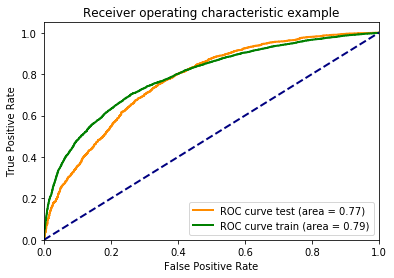

In [70]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc)
plt.plot(fpr_t, tpr_t, color='green',
         lw=lw, label='ROC curve train (area = %0.2f)' % roc_auc_t)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [71]:
# Using a treshold=0.5, we assign a class for all probability
y_result = np.where(y_result > 0.5, 1, 0)
y_train_result = np.where(y_train_result > 0.5, 1, 0)

In [72]:
confusion_matrix(y_test, y_result)

array([[1343,  730],
       [ 728, 2272]], dtype=int64)

In [4]:
15 - round(15/2)

7

In [20]:
a= (3,6,2,8,9)
b= (4,4,2,5,7)
c= ()

In [27]:
c += a
c += b

In [52]:
for i in range(int(len(c)/5)):
    print(i)

0
1
2
3


In [54]:
if value  == ((len(c)/5)-1)

4.0

In [36]:
len((19, 19, 5, 18, 19, 19, 19, 5, 19, 18, 19, 19, 5, 18, 18, 19, 19, 5, 18, 19, 19, 19, 5, 19, 18, 19, 19, 5, 18, 18))

30

In [46]:
a = (0,0)

all_move = ()

move_possible = []
if a[0] > 0:
    move_possible.append([-1,0])
if a[1] > 0:
    move_possible.append([0,-1])
if a[0] < 20:
    move_possible.append([1,0])
if a[1] < 20:
    move_possible.append([0,1])
if a[0] > 0 and a[1] > 0:
    move_possible.append([-1,-1])
if a[0] > 0 and a[1] < 20:
    move_possible.append([-1,1])
if a[0] < 20 and a[1] > 0:
    move_possible.append([1,-1])
if a[0] < 20 and a[1] < 20:
    move_possible.append([1,1])
        


In [51]:
from itertools import combinations

for i in combinations(move_possible,2):
    print(i)



([1, 0], [0, 1])
([1, 0], [1, 1])
([0, 1], [1, 1])


In [64]:
list1=[(0,1),(3,1),(1,1)]
list2=[(5,6),(6,5),(0,1)]



for i in list(itertools.product(list1, list2)):
    print(i[0]+i[1])

([(0, 1), (3, 1), (1, 1)],)
([(5, 6), (6, 5), (0, 1)],)
